This notebook showcases how the data for pytorch captioning tutorial was originally obtained.

Running this script is not necessary to complete the basic assignment as __you will be given preprocessed data__ produced by this notebook. The script itself takes hours

However, if one wants to implement e.g. attentive captioning with attention casted into earlier layers in the network OR try a different network architecture, one is invited to change this code at will. 
GPU(s), high-speed internet and ~50G of disc space are recommended.

In [1]:
# Obtaining the data:
# download stuff from http://cocodataset.org/#download
# !curl http://images.cocodataset.org/zips/train2017.zip > train2017.zip
# !curl http://images.cocodataset.org/zips/val2017.zip > val2017.zip
# !curl http://images.cocodataset.org/annotations/annotations_trainval2017.zip > annotations_trainval2017.zip

# !unzip annotations_trainval2017.zip
# !unzip train2017.zip > log
# !unzip val2017.zip > log

In [2]:
# sanity check
!du -h --max-depth=1 .

884K	./.ipynb_checkpoints
2,1M	.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%env CUDA_VISIBLE_DEVICES=0
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

env: CUDA_VISIBLE_DEVICES=0


In [6]:
# you may need to !pip install pycocotools
from torchvision.datasets import coco
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])
coco_train = coco.CocoCaptions("/home/waytobehigh/Yandex.Disk/Data/train2017/",
                               "/home/waytobehigh/Yandex.Disk/Data/annotations/captions_train2017.json",
                               transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=coco_train, batch_size=32, shuffle=False, num_workers=4)

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


In [7]:
from torchvision.models.inception import Inception3
from warnings import warn
class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x

In [8]:
from torch.utils.model_zoo import load_url
model= BeheadedInception3(transform_input=True)

inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
model.load_state_dict(load_url(inception_url))

model = nn.DataParallel(model.train(False).cuda())

# Sanity check

Test-run NN over one batch. NN labels shouldn't be completely absurd.

/home/waytobehigh/ds/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


NN shapes
before_pool: (32, 2048, 8, 8)
after_pool: (32, 2048)
logits: (32, 1000)
# 0


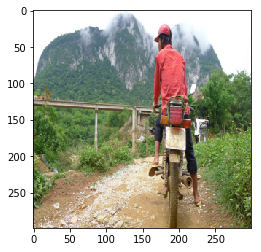

Captions
('A man with a red helmet on a small moped on a dirt road. ', 'Man riding a motor bike on a dirt road on the countryside.', 'A man riding on the back of a motorcycle.', 'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ', 'A man in a red shirt and a red hat is on a motorcycle on a hill side.')
NN classes
['mountain bike, all-terrain bike, off-roader', 'alp', 'chain saw, chainsaw', 'valley, vale', 'stretcher']
# 3


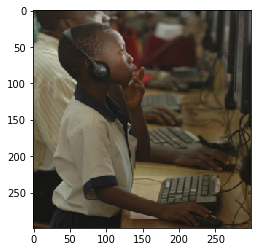

Captions
('A young boy standing in front of a computer keyboard.', 'a little boy wearing headphones and looking at a computer monitor', 'He is listening intently to the computer at school.', 'A young boy stares up at the computer monitor.', 'a young kid with head phones on using a computer ')
NN classes
['gasmask, respirator, gas helmet', 'cellular telephone, cellular phone, cellphone, cell, mobile phone', 'lab coat, laboratory coat', 'microphone, mike', 'oxygen mask']
# 6


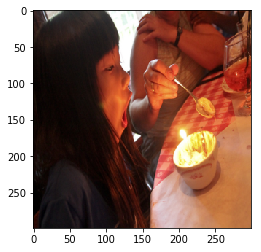

Captions
('A young girl inhales with the intent of blowing out a candle. ', 'A young girl is preparing to blow out her candle.', 'A kid is to blow out the single candle in a bowl of birthday goodness. ', 'Girl blowing out the candle on an ice-cream ', 'A little girl is getting ready to blow out a candle on a small dessert.')
NN classes
['candle, taper, wax light', 'oxygen mask', 'bubble', 'hot pot, hotpot', 'caldron, cauldron']
# 9


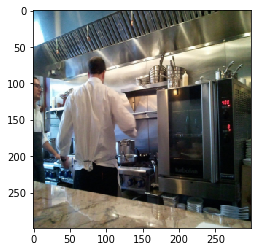

Captions
('Two chefs in a restaurant kitchen preparing food. ', 'Two cooks are cooking the food someone ordered at this restaurant', 'The chef is cooking with pans on the stove next to an oven. ', 'Two men that are standing in a kitchen.', 'Two cooks are near the stove in a stainless steel kitchen.')
NN classes
['lab coat, laboratory coat', 'restaurant, eating house, eating place, eatery', 'rotisserie', 'bakery, bakeshop, bakehouse', 'sliding door']


In [8]:
img_batch, capt_batch = next(iter(data_loader))

# captions batch is transposed in our version. Check if the same is true for yours
capt_batch = list(zip(*capt_batch))
img_batch = Variable(img_batch, volatile=True)
vec_batch_for_attn, vec_batch, logits_batch  = [var.cpu().data.numpy() for var in model(img_batch)]

print("NN shapes")
print('before_pool:', np.shape(vec_batch_for_attn))
print('after_pool:', np.shape(vec_batch))
print('logits:', np.shape(logits_batch))


# class labels
import requests
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

for i in range(0, 10, 3):
    print("#", i)
    plt.imshow(img_batch[i].data.cpu().numpy().transpose([1,2,0]))
    plt.show()
    print('Captions')
    print(capt_batch[i])

    top_ix = (-logits_batch[i]).argsort()
    print('NN classes')
    print(list(map(labels.get, top_ix[:5])))

# Actually transforming data

Note: this part may consume a lot of RAM. If your's a bit limited:
* Do not store vectors that you don't need (e.g. vectors_before_pool if no attention)
* Save everything on a disk every K iterations and free the memory.
    * They ya'll have to manually read it.

In [ ]:
from tqdm import tqdm
vectors_before_pool, vectors, logits, captions = [], [], [], []
for img_batch, capt_batch in tqdm(data_loader):
    capt_batch = list(zip(*capt_batch))
    img_batch = Variable(img_batch, volatile=True)
    vec_batch_for_attn, vec_batch, logits_batch  = [var.cpu().data.numpy() for var in model(img_batch)]

    captions.extend(capt_batch)
    vectors.extend([vec for vec in vec_batch])
    
    ## WARNING! If you're low on ram, comment this line.
    vectors_before_pool.extend([vec for vec in vec_batch_for_attn])
    

  0%|          | 0/3697 [00:00<?, ?it/s]/home/waytobehigh/ds/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
  7%|▋         | 251/3697 [00:34<07:50,  7.32it/s]

In [ ]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

captions_tokenized = [[' '.join(filter(len, tokenizer.tokenize(cap.lower()))) 
                           for cap in img_captions]
                                for img_captions in tqdm(captions)]

In [ ]:
i = 123
print("Original:\n%s\n\n" % '\n'.join(captions[i]))
print("Tokenized:\n%s\n\n"% '\n'.join(captions_tokenized[i]))

# Save everything
May take a couple of minutes depending on hdd/sdd speed.

In [13]:
!mkdir data
np.save("./data/image_codes.npy", np.asarray(vectors))
np.save("./data/image_codes_for_attn.npy", np.asarray(vectors_before_pool))
np.save('./data/image_logits.npy', np.asarray(logits))

import json
with open('./data/captions.json', 'w') as f_cap:
    json.dump(captions, f_cap)
with open('./data/captions_tokenized.json', 'w') as f_cap:
    json.dump(captions_tokenized, f_cap)

In [14]:
# sanity check
!du -h --max-depth=1 .
!ls -lht data

452K	./.ipynb_checkpoints
796M	./annotations
19G	./train2017
60G	./handout
788M	./val2017
112G	.
total 60G
-rw-rw-r-- 1 jheuristic jheuristic  33M мар 17 16:18 captions_tokenized.json
-rw-rw-r-- 1 jheuristic jheuristic  33M мар 17 16:18 captions.json
-rw-rw-r-- 1 jheuristic jheuristic 452M мар 17 16:18 image_logits.npy
-rw-rw-r-- 1 jheuristic jheuristic  58G мар 17 16:18 image_codes_for_attn.npy
-rw-rw-r-- 1 jheuristic jheuristic 925M мар 17 16:15 image_codes.npy
